In [1]:
import pandas as pd
from dython.nominal import associations
from sklearn.cluster import DBSCAN

from gower.gower_dist import *

# Simple example from D'Orazio

In [2]:
df = pd.DataFrame({"Sex1": ["M", "M", "F", "F", "F", "M", "M", "F", "F", "F"],
                   "Sex2": ["M", "M", "F", "F", "F", "F", "F", "M", "M", "M"],
                   "Age1": [15] * 10,
                   "Age2": [15, 36, 58, 78, 100, 15, 36, 58, 78, 100]})

In [3]:
distances = np.diag(gower_matrix(df[["Sex1", "Age1"]].to_numpy(), df[["Sex2", "Age2"]].to_numpy()))
print(distances)
df.loc[np.argsort(distances)]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[1.] [2.38552791]


  0%|          | 0/10 [00:00<?, ?it/s]

[0.         0.17408385 0.3564574  0.52225154 0.70462509 0.29537491
 0.46945876 0.65183231 0.81762645 1.        ]


,Sex1,Sex2,Age1,Age2
0,M,M,15,15
1,M,M,15,36
5,M,F,15,15
2,F,F,15,58
6,M,F,15,36
3,F,F,15,78
7,F,M,15,58
4,F,F,15,100
8,F,M,15,78
9,F,M,15,100


# Metrics

### We can also use the categorical weight function to measure cluster quality and thereby tune clustering algorithms such as DBSCAN.

##### I calculated Gower distances for each of the four datasets above using the new weighting scheme, and then ran a grid search with DBSCAN based on the new weighting formula for categorical variables.

# Istanbul dataset

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[1.         0.58117555 0.27820855 0.99078148 0.6722523 ] [4.93182563 2.38629436 3.48114226]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

({'eps': 0.1, 'min_samples': 1}, 0.7373161389227045)
(array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   21,   22,   23,
         24,   25,   28,   32,   34,   36,   37,   40,   42,   45,   46,
         70,  114, 2476]), array([2142,  614,  226,  131,   94,   54,   35,   26,   19,   12,   10,
         10,    9,    5,    6,    6,    1,    3,    1,    1,    2,    2,
          1,    1,    1,    1,    1,    1,    2,    1,    1,    1,    1,
          1,    1,    1]))


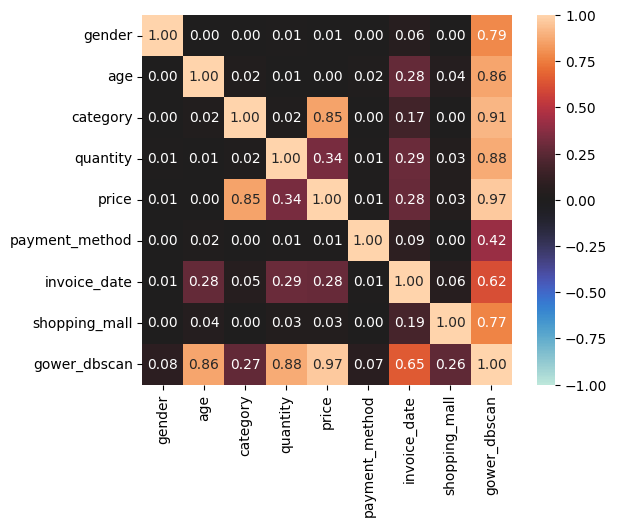

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,gower_dbscan,label_count
35103,Male,43,Clothing,3,900.24,Debit Card,8/1/2023,Mall of Istanbul,1,2476
80358,Female,21,Clothing,2,600.16,Debit Card,24/04/2021,Kanyon,1,2476
12049,Female,49,Cosmetics,2,81.32,Cash,17/12/2021,Metrocity,1,2476
46476,Female,45,Food & Beverage,1,5.23,Cash,7/8/2021,Metrocity,1,2476
61875,Male,30,Clothing,2,600.16,Cash,29/03/2021,Mall of Istanbul,1,2476
...,...,...,...,...,...,...,...,...,...,...
9669,Male,25,Souvenir,3,35.19,Credit Card,4/2/2021,Kanyon,99,1
85045,Female,55,Technology,4,4200.00,Cash,23/04/2022,Metrocity,991,1
67671,Male,51,Technology,2,2100.00,Debit Card,10/8/2021,Istinye Park,994,1
55359,Male,43,Food & Beverage,5,26.15,Cash,24/02/2022,Viaport Outlet,995,1


In [4]:
istanbul = pd.read_csv("customer_shopping_data.csv").sample(10000).iloc[:, 2:]  # no nulls!

matrix4 = gower_matrix(istanbul.to_numpy(), chunksize=20)

samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 101)]

results4 = process_map(partial(do_it, matrix=matrix4), samples, chunksize=1)

best_params4 = max(results4, key=lambda z: z[1])

print(best_params4)

istanbul["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params4[0]).fit_predict(matrix4)
istanbul.gower_dbscan = istanbul.gower_dbscan.astype(str)

_, counts4 = np.unique(istanbul["gower_dbscan"], return_counts=True)

print(np.unique(counts4, return_counts=True))

associations(istanbul, nom_nom_assoc="theil", plot=True)

istanbul["label_count"] = istanbul.groupby("gower_dbscan").transform("count").iloc[:, 0]

istanbul.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

istanbul


# Dog adoption dataset

breed_secondary
color_primary
color_secondary
color_tertiary
declawed
env_cats


  0%|          | 0/28 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[0.97543628 0.86564359 0.         0.         0.85469533 1.
 0.         0.39354322 1.         0.34286435 0.29805301 1.
 1.         1.         1.         1.         1.         0.9374939
 0.         0.86568453 0.97397479 0.87246691 0.97597998 1.
 0.83097843 0.         0.         0.87078993] []


  0%|          | 0/13729 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

({'eps': 0.33, 'min_samples': 1}, 0.8910199899850122)
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  45,  46,  47,  49,  50,  54,  55,  56,  57,
        58,  60,  64,  68,  69,  73,  78,  82,  83, 105, 108, 119, 134,
       153, 212]), array([1969,  415,  224,  131,  109,   78,   54,   36,   45,   31,   31,
         25,   27,   19,   15,   11,   16,   11,   15,    9,    7,   10,
          4,    5,    6,    6,    4,    4,    5,    3,    3,    3,    2,
          1,    4,    1,    2,    3,    5,    1,    3,    1,    1,    2,
          2,    1,    1,    1,    1,    1,    1,    1,    1,    3,    1,
          1,    2,    1,    1,    1,    1,    2,    1,    1,    1,    1,
          1]))


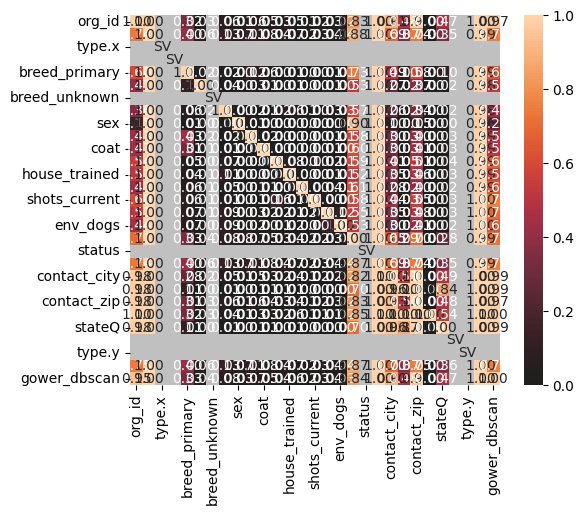

,org_id,url,type.x,species,breed_primary,breed_mixed,breed_unknown,age,sex,size,...,contact_city,contact_state,contact_zip,contact_country,stateQ,accessed,type.y,description,gower_dbscan,label_count
id,,,,,,,,,,,,,,,,,,,,,
46021535,TX2394,https://www.petfinder.com/dog/brody-bear-46021...,Dog,Dog,Schnauzer,True,False,Baby,Male,Small,...,Brattleboro,VT,05301,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Brody! ...,381,212
46021378,TX2394,https://www.petfinder.com/dog/brody-46021378/c...,Dog,Dog,Schnauzer,True,False,Baby,Male,Small,...,Groton,CT,06340,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Brody! ...,381,212
46021361,TX2394,https://www.petfinder.com/dog/daisey-may-46021...,Dog,Dog,Weimaraner,True,False,Young,Female,Medium,...,Brattleboro,VT,05301,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Daisey M...,381,212
46021331,TX2394,https://www.petfinder.com/dog/daisey-mae-46021...,Dog,Dog,Weimaraner,True,False,Young,Female,Medium,...,Boston,MA,02128,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Daisey M...,381,212
46021276,TX2394,https://www.petfinder.com/dog/daisey-mae-3-460...,Dog,Dog,Weimaraner,True,False,Young,Female,Medium,...,Groton,CT,06340,US,CT,2019-09-20,Dog,Howdy! Caught you looking! My name is Daisey M...,381,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45175958,CT407,https://www.petfinder.com/dog/kiki-sweet-senio...,Dog,Dog,Australian Shepherd,True,False,Senior,Female,Medium,...,York,PA,17408,US,DC,2019-09-20,Dog,Kiki is being fostered in PA. Blind Dog Rescue...,994,1
45174585,NY695,https://www.petfinder.com/dog/shadow-in-pa-goo...,Dog,Dog,Great Pyrenees,True,False,Young,Male,Extra Large,...,Harrisburg,PA,17103,US,DC,2019-09-20,Dog,NYS Registered Rescue # RR102\nView full listi...,995,1
45169398,CT407,https://www.petfinder.com/dog/roy-playful-pupp...,Dog,Dog,Labrador Retriever,True,False,Baby,Male,Medium,...,Carlisle,PA,17013,US,DC,2019-09-20,Dog,Roy is being fostered in PA. Blind Dog Rescue ...,996,1


In [5]:
dd = pd.read_csv("dog_adoption/allDogDescriptions.csv", index_col=0)
dd.set_index("id", inplace=True, drop=True)


# get rid of columns with the most destructive nans

def isolate_nans(column):
    all_other_nans = nans[[c for c in cols if c != column]].sum(axis=1)
    mask = all_other_nans < np.median(all_other_nans)
    mask &= nans[column]
    return mask.sum()


nans = dd.isna()
cols = dd.columns
isolated_nans = {c: isolate_nans(c) for c in cols}
median_count = np.median([v for v in isolated_nans.values() if v > 0])
for column, count in isolated_nans.items():
    if count > median_count:
        print(column)
        dd.drop(column, axis=1, inplace=True)
dd.dropna(inplace=True)  # dd.mode().iloc[0]

# make bools strings
is_bool = dd.dtypes == bool
dd.loc[:, is_bool] = dd[dd.columns[is_bool]].astype(str)

matrix = gower_matrix(dd.to_numpy(), chunksize=20)
samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 101)]
results = process_map(partial(do_it, matrix=matrix), samples, chunksize=1)
best_params = max(results, key=lambda z: z[1])
print(best_params)
dd["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params[0]).fit_predict(matrix)
dd.gower_dbscan = dd.gower_dbscan.astype(str)
_, counts = np.unique(dd["gower_dbscan"], return_counts=True)
print(np.unique(counts, return_counts=True))

associations(dd, nom_nom_assoc="theil", plot=True)

dd["label_count"] = dd.groupby("gower_dbscan").transform("count").iloc[:, 0]
dd.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

dd


# Laptops dataset

(977, 12)
Model Name                  488
Category                      6
Screen Size                  18
Screen                       38
CPU                         106
RAM                           8
 Storage                     36
GPU                          98
Operating System              7
Operating System Version      5
Weight                      166
Price                       639
dtype: int64


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[0.42297016 0.54058907 0.62092444 0.80832039 0.47029116 0.67940571
 0.78557714 0.25159879 0.88937836] [5.56252241]


  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

({'eps': 0.135, 'min_samples': 1}, 0.6666025946253947)
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  14,  16,
        29,  55, 199]), array([349,  56,  11,   5,   6,   5,   4,   4,   1,   1,   1,   1,   1,
         1,   1,   1]))


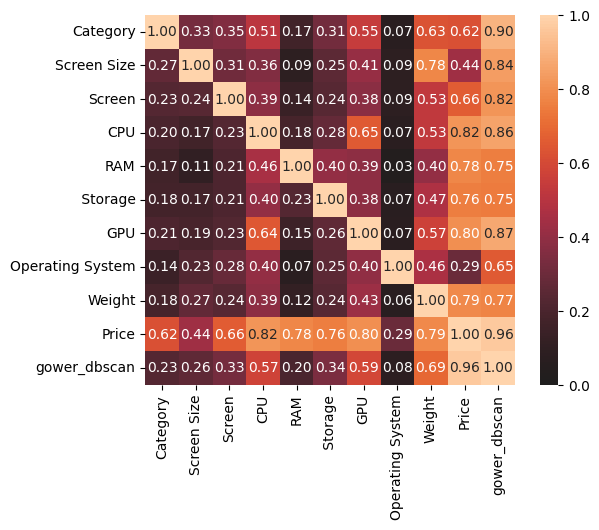

,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Weight,Price,gower_dbscan,label_count
Manufacturer,,,,,,,,,,,,
HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,5112900.00,2,199
HP,Notebook,"15.6""",1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,3502558.80,2,199
HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,No OS,1.86kg,3067651.08,2,199
Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows,2.2kg,4436218.80,2,199
Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,AMD Radeon R5 M430,Windows,2.2kg,6624540.00,2,199
...,...,...,...,...,...,...,...,...,...,...,...,...
Huawei,Ultrabook,"13.0""",IPS Panel Full HD 2160x1440,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,1.05kg,11995308.00,92,1
HP,Notebook,"17.3""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,6GB,2TB HDD,AMD Radeon 520,Windows,2.71kg,6215508.00,93,1
Lenovo,Notebook,"15.6""",1366x768,AMD A6-Series 9220 2.9GHz,4GB,500GB HDD,AMD Radeon R4 Graphics,No OS,2.2kg,2747628.00,94,1


In [6]:
laptops = pd.read_csv("laptops/laptops_train.csv", index_col=0)
print(laptops.shape)
print(laptops.apply(lambda col: col.unique(), axis=0).apply(len))
laptops.drop(["Operating System Version", "Model Name"], axis=1, inplace=True)

matrix3 = gower_matrix(laptops.to_numpy(), chunksize=20)
samples = [{"eps": z / 1000, "min_samples": 1} for z in range(1, 1001)]
results3 = process_map(partial(do_it, matrix=matrix3), samples, chunksize=20)
best_params3 = max(results3, key=lambda z: z[1])
print(best_params3)
laptops["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params3[0]).fit_predict(matrix3)
laptops.gower_dbscan = laptops.gower_dbscan.astype(str)
_, counts3 = np.unique(laptops["gower_dbscan"], return_counts=True)
print(np.unique(counts3, return_counts=True))

associations(laptops, nom_nom_assoc="theil", plot=True)

laptops["label_count"] = laptops.groupby("gower_dbscan").transform("count").iloc[:, 0]
laptops.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

laptops


# Pokemon dataset

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[0.77247169 0.57270837 1.         0.69349432 1.         0.71452682
 0.4098755  1.         0.69636799] [5.57126785 4.659814   5.34436533 5.00478207 5.29629323 4.6100858
 5.31898999 2.60943791 2.73286795 3.8288446  4.61876915 4.33115688]


  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

({'eps': 0.08, 'min_samples': 1}, 0.5809934516398402)
(array([  1,   2,   3,   4,   5,   8,  11,  12, 251]), array([307,  34,  12,   2,   4,   1,   1,   1,   1]))


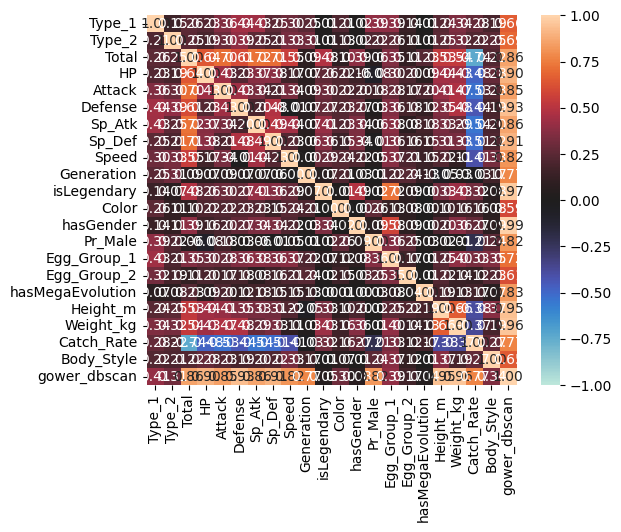

,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,...,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,gower_dbscan,label_count
0,Grass,Poison,318,45,49,49,65,65,45,1,...,0.875,Monster,Grass,False,0.71,6.9,45,quadruped,0,251
1,Grass,Poison,405,60,62,63,80,80,60,1,...,0.875,Monster,Grass,False,0.99,13.0,45,quadruped,0,251
3,Fire,none,309,39,52,43,60,50,65,1,...,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed,0,251
4,Fire,none,405,58,64,58,80,65,80,1,...,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed,0,251
5,Fire,Flying,534,78,84,78,109,85,100,1,...,0.875,Monster,Dragon,True,1.70,90.5,45,bipedal_tailed,0,251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Water,Ground,210,55,45,45,25,25,15,2,...,0.500,Water_1,Field,False,0.41,8.5,255,head_legs,93,1
196,Dark,none,525,95,65,110,60,130,65,2,...,0.875,Field,none,False,0.99,27.0,45,quadruped,94,1
201,Psychic,none,405,190,33,58,33,58,33,2,...,0.500,Amorphous,none,False,1.30,28.5,45,head_base,97,1
204,Bug,Steel,465,75,90,140,60,60,40,2,...,0.500,Bug,none,False,1.19,125.8,75,head_only,98,1


In [7]:
pokemon = pd.read_csv("pokemon/pokemon_alopez247.csv").iloc[:, 2:]
for c in pokemon.columns[pokemon.dtypes != object]:
    pokemon.loc[pokemon[c].isna(), c] = np.nanmedian(pokemon[c])
for c in pokemon.columns[pokemon.dtypes == object]:
    pokemon.loc[pokemon[c].isna(), c] = "none"

matrix2 = gower_matrix(pokemon.to_numpy(), chunksize=20)
samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 1001)]
results2 = process_map(partial(do_it, matrix=matrix2), samples, chunksize=20)
best_params2 = max(results2, key=lambda z: z[1])
print(best_params2)
pokemon["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params2[0]).fit_predict(matrix2)
pokemon.gower_dbscan = pokemon.gower_dbscan.astype(str)
_, counts2 = np.unique(pokemon["gower_dbscan"], return_counts=True)
print(np.unique(counts2, return_counts=True))

associations(pokemon, nom_nom_assoc="theil", plot=True)

pokemon["label_count"] = pokemon.groupby("gower_dbscan").transform("count").iloc[:, 0]
pokemon.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

pokemon
